In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import random

class environment_q_learning:
    def __init__(self,type_of_env:str,gamma_disc: float, epsilon:float,epsilon_decay:float,learning_rate:float,no_of_episodes:int,max_time_steps:int):
        
        self.chain_of_states = []
        self.chain_of_actions = []
        self.chain_of_rewards = []
        if max_time_steps < 10:
            raise ValueError("Timesteps should be greater than of equal to 10")
        
        if (epsilon_decay > 1) or (epsilon_decay < 0):
            raise ValueError("Epsilon decay should be less than 1 and greater than 0")
        
        if no_of_episodes < 1:
            raise ValueError("No of Episodes should be atleast equal to 1")

        # No of number of states = 25 - Requirement 1
        self.environment = np.zeros((5,5))

        # No of actions an agent can take:
        self.action_set_size = 4

        self.gamma = gamma_disc
        # Q Value Learning Table
        # self. = np.zeros((len(self.environment.flatten())),self.action_set_size)
        self.qvalue_table = {}
        for i1 in range(5):
            for i2 in range(5):
                for i in np.zeros((25,4)):
                    self.qvalue_table[(i1,i2)] = i
        
        self.max_timesteps = max_time_steps
        self.current_time_steps = 0
        
        # This determines the exploitation vs exploration phase.
        self.epsilon = epsilon

        # this determines the reduction in epsilon
        self.epsilon_decay = epsilon_decay

        # this determines how quickly the q values for a state are updated
        self.learning_rate = learning_rate

        # this tells us the no_of_epsiodes during which we will determine the optimal q value
        self.no_of_episodes = no_of_episodes
        self.current_episode = 1
        
        self.goal_pos = [4,4]
        self.agent_current_pos = [0,0]
        self.done_or_not = False

        self.environment[tuple(self.agent_current_pos)] = 1
        self.environment[tuple(self.goal_pos)] = 0.5

        # Collection of Rewards (the keys) and associated values (the states). -> Total No of Rewards = 4 -> Requirement 3
        self.rewards = [{-1:[0,3]},{-1:[3,0]},{3:[2,3]},{3:[3,2]}]
        self.reward_states = [(0,3),(3,0),(2,3),(3,2)]
        # Setting the colors for the reward states in the environment.
        for reward_state in self.rewards:
            for reward, position in reward_state.items():
                self.environment[tuple(position)] = reward

        # Either Deterministic or stochastic.
        self.environment_type = type_of_env

        # This tracks the reward for the agent.
        self.cumulative_reward = 0

    def reset(self):
        # Here we are essentially resetting all the values.
        self.current_time_steps = 0
        self.cumulative_reward = 0
        self.chain_of_states = []
        self.chain_of_actions = []
        self.chain_of_rewards = []

        self.goal_pos = [4,4]
        self.agent_current_pos = [0,0]
        
        self.environment = np.zeros((5,5))
        
        self.rewards = [{-1:[0,3]},{-1:[3,0]},{3:[2,3]},{3:[3,2]},{5:[4,4]}]
        self.reward_states = [(0,3),(3,0),(2,3),(3,2),[4,4]]
        
        for reward in self.rewards:
            for reward, position in reward.items():
                self.environment[tuple(position)] = reward

        self.environment[self.agent_current_pos] = 1
        self.environment[self.goal_pos] = 0.5
    
    def step(self):
        # print("Steps starting agent pos is", self.agent_current_pos)
        # We are checking wether the environment is deterministic or stochastic
        if self.environment_type == 'deterministic':
            # In Deterministic environments, there is no use for epsilon as all the actions are deterministic / greedy / pre-determined.
            
            self.current_time_steps +=1

            all_possible_actions = self.get_all_possible_actions(self.agent_current_pos)
            states_the_actions_lead_to = self.get_states_for_actions(all_possible_actions,self.agent_current_pos)

            selected_action, selected_state = self.return_state_action_pair(all_possible_actions,states_the_actions_lead_to)
            
            self.agent_current_pos = selected_state
            self.chain_of_states.append(selected_state)
            self.chain_of_actions.append(selected_action)
            self.chain_of_rewards.append(self.check_and_get_reward(selected_state))

            breaker = False
            for reward_state_counter in range(len(self.rewards)):
                for reward, state in self.rewards[reward_state_counter].items():
                    # if the reward state matches the agents, sum the cum reward and delete that particular reward state space.

                    if state == self.agent_current_pos:
                        self.cumulative_reward += reward
                        del self.rewards[reward_state_counter]
                        breaker = True
                        break

                if breaker:
                    break
            
            # We are now re-visualizing the environment
            self.environment = np.zeros((5,5)) 

            for reward_state_counter in range(len(self.rewards)):
                for reward, position in self.rewards[reward_state_counter].items():
                    self.environment[tuple(position)] = reward
                
            self.environment[tuple(self.goal_pos)] = 0.5
            self.environment[tuple(self.agent_current_pos)] = 1
            
            # if the agent has reached the final state then done
            if (self.agent_current_pos == self.goal_pos) or (self.current_time_steps == self.max_timesteps):
                self.done_or_not = True
            
            else:
                self.done_or_not = False
            
            return self.environment.flatten, self.cumulative_reward, self.done_or_not, self.current_time_steps
        elif self.environment_type == 'stochastic':
            # In Deterministic environments, there is no use for epsilon as all the actions are deterministic / greedy / pre-determined.
            
            self.current_time_steps +=1

            all_possible_actions = self.get_all_possible_actions(self.agent_current_pos)
            states_the_actions_lead_to = self.get_states_for_actions(all_possible_actions,self.agent_current_pos)

            selected_action, selected_state = self.return_state_action_pair(all_possible_actions,states_the_actions_lead_to)
            
            selected_action, selected_state = self.return_final_stochastic(selected_action, selected_state,all_possible_actions,states_the_actions_lead_to)

            self.agent_current_pos = selected_state
            self.chain_of_states.append(selected_state)
            self.chain_of_actions.append(selected_action)
            self.chain_of_rewards.append(self.check_and_get_reward(selected_state))

            breaker = False
            for reward_state_counter in range(len(self.rewards)):
                for reward, state in self.rewards[reward_state_counter].items():
                    # if the reward state matches the agents, sum the cum reward and delete that particular reward state space.

                    if state == self.agent_current_pos:
                        self.cumulative_reward += reward
                        del self.rewards[reward_state_counter]
                        breaker = True
                        break

                if breaker:
                    break
            
            # We are now re-visualizing the environment
            self.environment = np.zeros((5,5)) 

            for reward_state_counter in range(len(self.rewards)):
                for reward, position in self.rewards[reward_state_counter].items():
                    self.environment[tuple(position)] = reward
                
            self.environment[tuple(self.goal_pos)] = 0.5
            self.environment[tuple(self.agent_current_pos)] = 1
            
            # if the agent has reached the final state then done
            if (self.agent_current_pos == self.goal_pos) or (self.current_time_steps == self.max_timesteps):
                self.done_or_not = True
            
            else:
                self.done_or_not = False
            
            return self.environment.flatten, self.cumulative_reward, self.done_or_not, self.current_time_steps
    
    def return_final_stochastic(self,selected_action, selected_state,all_possible_actions,states_the_actions_lead_to):

        remaining_actions = [x for x in all_possible_actions if x!=selected_action]
        remaining_states = [x for x in states_the_actions_lead_to if x!=selected_state]

        list_of_probabs = []
        probabs = (.20) / len(remaining_states)
        for i in range(len(remaining_states)):
            list_of_probabs.append(probabs)
        list_of_probabs.append(.80)
        
        remaining_states.append(selected_state)
        remaining_actions.append(selected_action)
        
        chosen_action = random.choices(remaining_actions,list_of_probabs)
        # print('chosen_action is, ',chosen_action)
        # print('remaining_states are, ',remaining_states)
        chosen_state = remaining_states[remaining_actions.index(chosen_action[0])]

        return chosen_action, chosen_state
        
    def return_state_action_pair(self,all_possible_actions,states_the_actions_lead_to):
        
        random_n_number = random.uniform(0, 1)
        random_action_proba = self.epsilon

        if random_n_number > random_action_proba:
            action_to_be_returned, state_to_be_returned, _, _ = self.get_best_state_on_q_value(self.agent_current_pos,all_possible_actions,states_the_actions_lead_to)
            return action_to_be_returned, state_to_be_returned
            
        else:
            action_to_be_returned, state_to_be_returned, _, _ = self.get_best_state_on_q_value(self.agent_current_pos,all_possible_actions,states_the_actions_lead_to)
            
            remaining_actions = [x for x in all_possible_actions if x!=action_to_be_returned]
            remaining_states = [x for x in states_the_actions_lead_to if x!=state_to_be_returned]
            
            action_to_be_returned = random.choice(remaining_actions)
            state_to_be_returned = remaining_states[remaining_actions.index(action_to_be_returned)]

            return action_to_be_returned, state_to_be_returned

    def get_best_state_on_q_value(self,current_state, all_possible_actions,states_the_actions_lead_to):
        current_max = None
        state_to_be_returned = None
        action_to_be_returned = None
        q_values_evaluated = None

        # if current_state == 

        for action,state in zip(all_possible_actions,states_the_actions_lead_to):
            # print('Current state in get_best_state_on_q : {}, action : {}'.format(current_state,action))

            if state == [4,4]:
                return action, state,0, 0 

            elif current_max == None:
                current_max= self.qvalue_table[tuple(current_state)][action]
                state_to_be_returned = state
                action_to_be_returned = action
                q_values_evaluated = self.qvalue_table[tuple(current_state)]

            elif current_max != None:
                max1 = self.qvalue_table[tuple(current_state)][action]
                if max1 > current_max:
                    current_max = max1
                    state_to_be_returned = state
                    action_to_be_returned = action
                    q_values_evaluated = self.qvalue_table[tuple(current_state)]

        return action_to_be_returned, state_to_be_returned, current_max, q_values_evaluated

    def get_best_state_on_reward(self,all_possible_actions, states_the_actions_lead_to):
        
        for action,state in zip(all_possible_actions,states_the_actions_lead_to):
            
            for i in range(len(self.rewards)):
                for key, value in self.rewards[i].items():
                    if value == state:
                        return action, state
        return None, None
                


    def get_state_based_on_action(self, action, state):
        state_copy = list(state).copy()
        if action == 0:
            # print('Up')
            state_copy[0] -=1
            return state_copy

        elif action == 1:
            # print('Down')
            state_copy[0] +=1
            return state_copy

        elif action == 2:
            # print('Our Left or the Agents Right')
            state_copy[1] -=1
            return state_copy

        elif action == 3:
            # print('Our Right or the Agents Left')
            state_copy[1] +=1
            return state_copy

    def check_and_get_reward(self, state_result):
        # print('checking rewards for, ', state_result)
        for i in range(len(self.rewards)):
            for key, value in self.rewards[i].items():
                if value == state_result:
                    # self.rewards.pop(i)
                    # print('found reward for state_result', state_result, value)
                    return key

        return 0

    # def get_all_q_values_for_states(self,all_actions,agent_state):
    def get_states_for_actions(self, all_actions, agent_state):
    
        temp_states = list(agent_state).copy() 
        # vals_to_be_returned = []
        states_considered = []

        for action_to_be_taken in all_actions:

            action_taken = self.get_state_based_on_action(action_to_be_taken,agent_state)
            
            states_considered.append(action_taken)

            agent_state = temp_states.copy()

        return states_considered

    def get_all_possible_actions(self,agent_current_pos):
        
        x_pos = agent_current_pos[0]
        y_pos = agent_current_pos[1]

        if (x_pos == 0) and (y_pos == 0):
            return [1,3]
        
        elif (x_pos == 4) and (y_pos == 0):
            return [0,3]
        
        elif (x_pos == 0) and (y_pos == 4):
            return [1,2]
        
        elif (x_pos == 0) and (y_pos <= 3):
            return [1,2,3]
        
        elif (x_pos <= 3) and (y_pos == 0):
            return [0,1,3]
        
        elif (x_pos == 4) and (y_pos <= 3 ):
            return [0,2,3]

        elif (x_pos < 4) and (y_pos == 4 ):
            return [0,2,1]

        elif (x_pos >=1) and (x_pos<4) and (y_pos >= 1) and (y_pos <4):
            return [0,1,2,3]

        elif (x_pos==4) and (y_pos == 4):
            return 'Yay youve won'
        else:
            return None

    def render(self):
        plt.imshow(self.environment)
        plt.show()

    def compute_q_values(self):
        self.chain_of_actions.reverse(), self.chain_of_states.reverse(), self.chain_of_rewards.reverse()
        # now for sarsa, we need to take an action1 from selected_state -> based on epsilon greedy
        # now that we have action1 and selected_state
        # get the q_value for that q[selected_state][action]

        for i in range(len(self.chain_of_rewards)-1):            
            old_q_value = self.qvalue_table[tuple(self.chain_of_states[i+1])][self.chain_of_actions[i]]
            
            all_possible_actions = self.get_all_possible_actions(self.chain_of_states[i])
            
            if not all_possible_actions == "Yay youve won":

                states_the_actions_lead_to = self.get_states_for_actions(all_possible_actions,self.chain_of_states[i])
                selected_action, selected_state = self.return_state_action_pair(all_possible_actions,states_the_actions_lead_to)     
                # print('SARSE returned : {} {}'.format(selected_action, selected_state))                                                              
                self.qvalue_table[tuple(self.chain_of_states[i+1])][self.chain_of_actions[i]] = old_q_value + self.learning_rate * (self.chain_of_rewards[i] + (self.gamma * self.qvalue_table[tuple(selected_state)][selected_action]) - old_q_value)
            else:
                self.qvalue_table[tuple(self.chain_of_states[i+1])][self.chain_of_actions[i]] = old_q_value + self.learning_rate * (self.chain_of_rewards[i] - old_q_value)

    def train(self):
        # done = False
        self.reward_per_episode = []
        self.epsilons = []
        self.epsilons.append(self.epsilon)
        for i in range(self.no_of_episodes):
            self.current_time_steps = 0
            self.done_or_not = False
            self.reset()
            while not self.done_or_not:
                observation, reward, self.done_or_not, _ = self.step()

                if self.done_or_not:
                    self.reward_per_episode.append(reward)

            self.compute_q_values()

            self.current_episode+=1
            if self.epsilon > 0:
                self.epsilon -= self.epsilon*self.epsilon_decay
            self.epsilons.append(self.epsilon)


# pprint(environment_q_learning_obj.qvalue_table)
# pprint(environment_q_learning_obj.chain_of_states)

Epsilon: 0.3, Gamma: 0.3, lr : 0.3


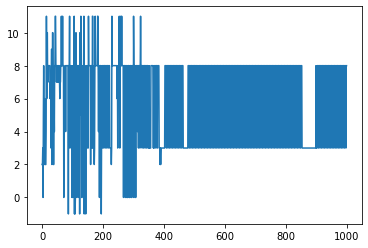

Epsilon: 0.3, Gamma: 0.6, lr : 0.3


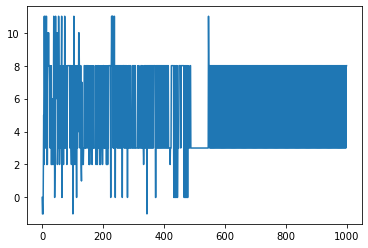

Epsilon: 0.3, Gamma: 0.9, lr : 0.3


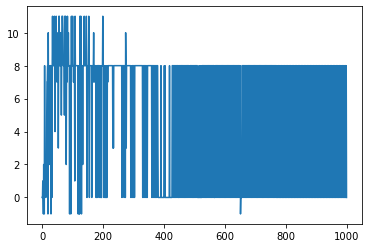

Epsilon: 0.3, Gamma: 0.3, lr : 0.5


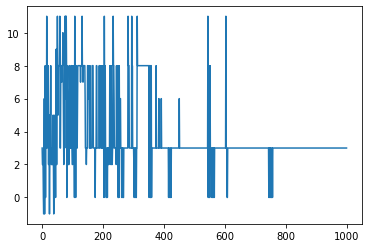

Epsilon: 0.3, Gamma: 0.6, lr : 0.5


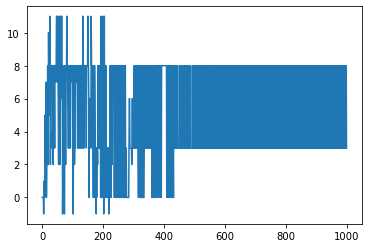

Epsilon: 0.3, Gamma: 0.9, lr : 0.5


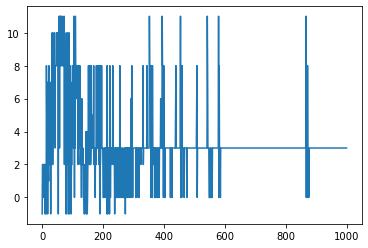

Epsilon: 0.3, Gamma: 0.3, lr : 0.7


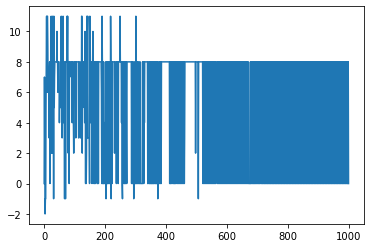

Epsilon: 0.3, Gamma: 0.6, lr : 0.7


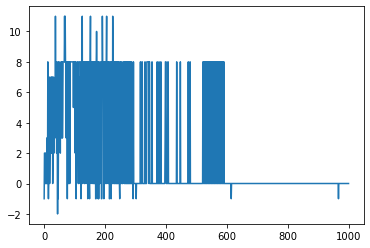

Epsilon: 0.3, Gamma: 0.9, lr : 0.7


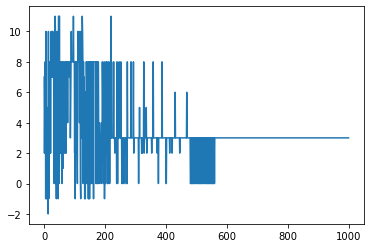

Epsilon: 0.5, Gamma: 0.3, lr : 0.3


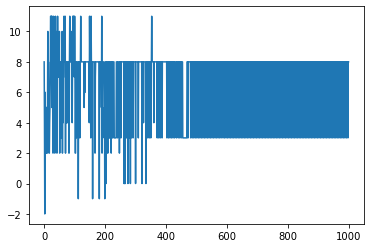

Epsilon: 0.5, Gamma: 0.6, lr : 0.3


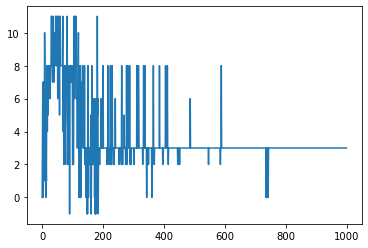

Epsilon: 0.5, Gamma: 0.9, lr : 0.3


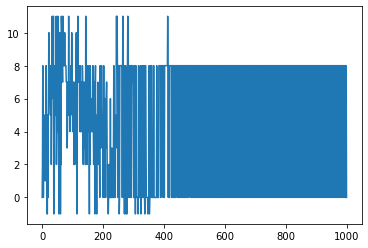

Epsilon: 0.5, Gamma: 0.3, lr : 0.5


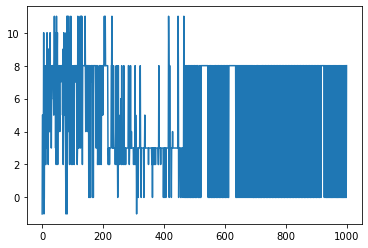

Epsilon: 0.5, Gamma: 0.6, lr : 0.5


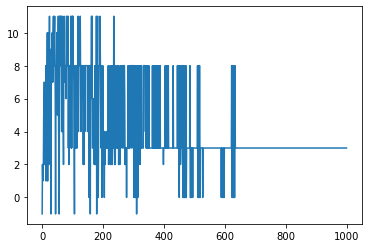

Epsilon: 0.5, Gamma: 0.9, lr : 0.5


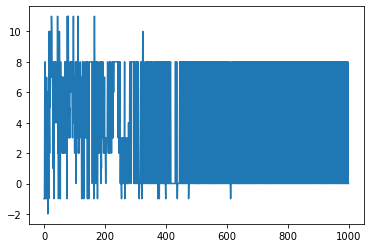

Epsilon: 0.5, Gamma: 0.3, lr : 0.7


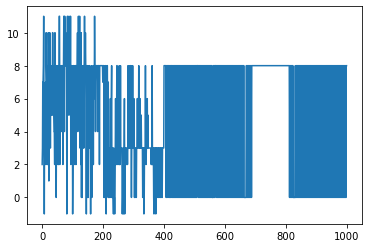

Epsilon: 0.5, Gamma: 0.6, lr : 0.7


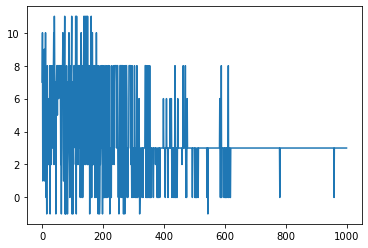

Epsilon: 0.5, Gamma: 0.9, lr : 0.7


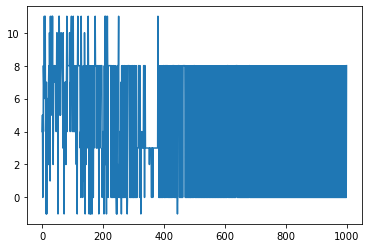

Epsilon: 0.7, Gamma: 0.3, lr : 0.3


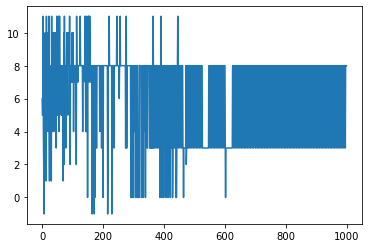

Epsilon: 0.7, Gamma: 0.6, lr : 0.3


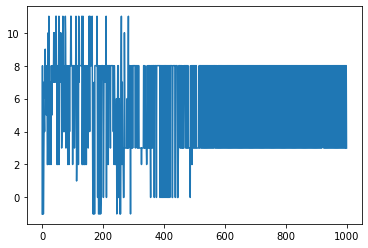

Epsilon: 0.7, Gamma: 0.9, lr : 0.3


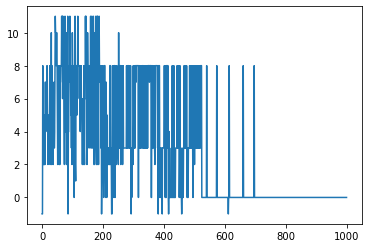

Epsilon: 0.7, Gamma: 0.3, lr : 0.5


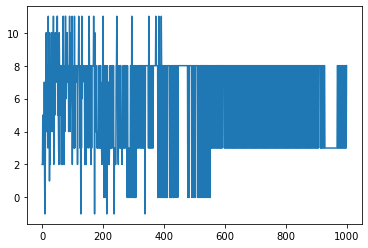

Epsilon: 0.7, Gamma: 0.6, lr : 0.5


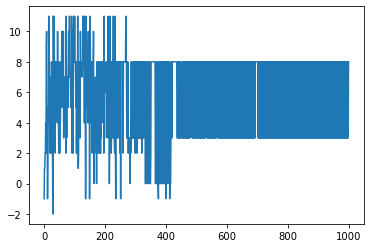

Epsilon: 0.7, Gamma: 0.9, lr : 0.5


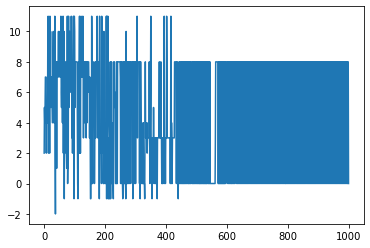

Epsilon: 0.7, Gamma: 0.3, lr : 0.7


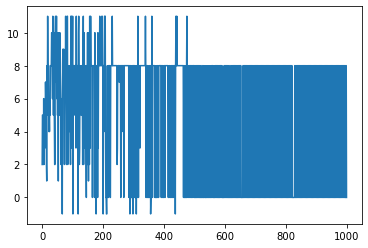

Epsilon: 0.7, Gamma: 0.6, lr : 0.7


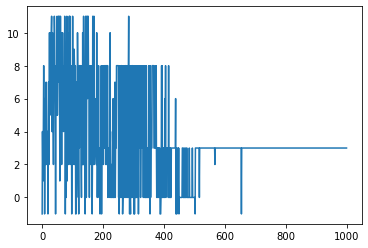

Epsilon: 0.7, Gamma: 0.9, lr : 0.7


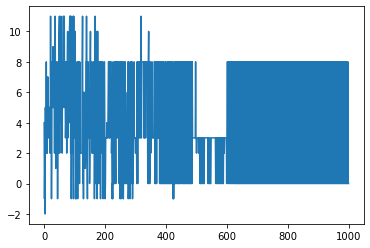

Epsilon: 0.9, Gamma: 0.3, lr : 0.3


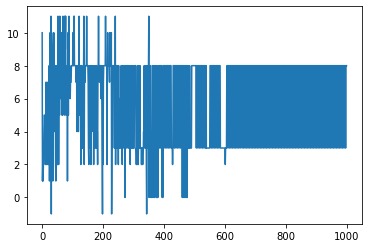

Epsilon: 0.9, Gamma: 0.6, lr : 0.3


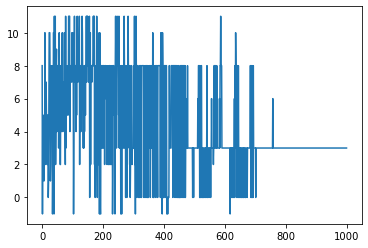

Epsilon: 0.9, Gamma: 0.9, lr : 0.3


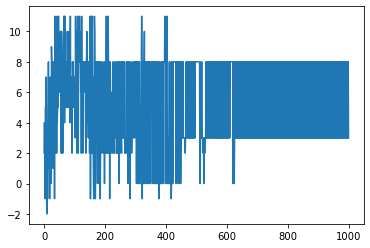

Epsilon: 0.9, Gamma: 0.3, lr : 0.5


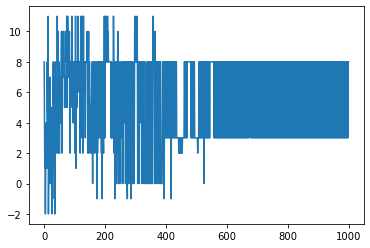

Epsilon: 0.9, Gamma: 0.6, lr : 0.5


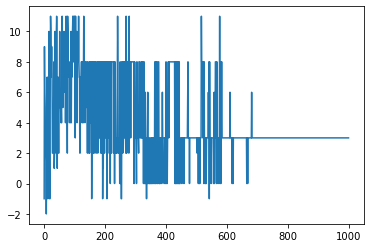

Epsilon: 0.9, Gamma: 0.9, lr : 0.5


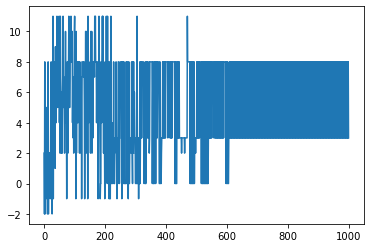

Epsilon: 0.9, Gamma: 0.3, lr : 0.7


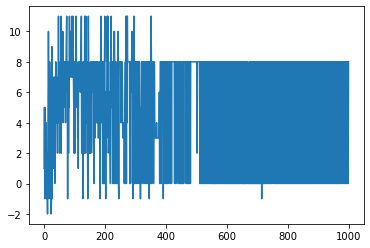

Epsilon: 0.9, Gamma: 0.6, lr : 0.7


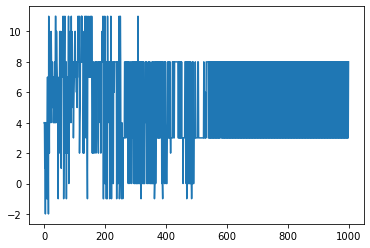

Epsilon: 0.9, Gamma: 0.9, lr : 0.7


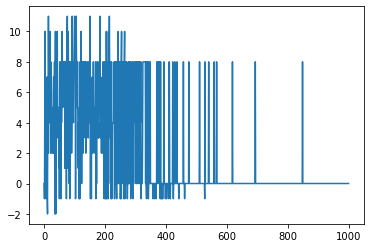

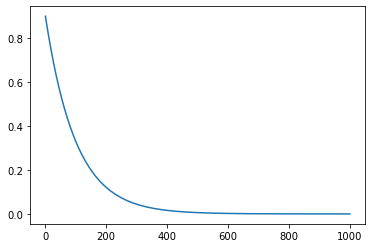

In [37]:
for epsilon in [0.3,0.5,0.7,0.9]:
    for learning_rate in [0.3,0.5,0.7]:
        for gamma_disc in [0.3,0.6,0.9]:
            
            print("Epsilon: {}, Gamma: {}, lr : {}".format(epsilon,gamma_disc,learning_rate))
            environment_q_learning_obj = environment_q_learning(type_of_env = 'deterministic',gamma_disc=gamma_disc,epsilon=epsilon,epsilon_decay=0.01,learning_rate=learning_rate,no_of_episodes=1000,max_time_steps=40)
            environment_q_learning_obj.train()
            plt.plot(environment_q_learning_obj.reward_per_episode)
            plt.show()
plt.plot(environment_q_learning_obj.epsilons)